In [221]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.inspection import permutation_importance

from fairlearn.metrics import (
    MetricFrame,
    selection_rate,
    demographic_parity_difference,
    demographic_parity_ratio,
    true_positive_rate,
    false_positive_rate
)
from fairlearn.postprocessing import ThresholdOptimizer

import matplotlib.pyplot as plt

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)

In [222]:
# --- Load the Adult Dataset (Train + Test Combined) ---

cols = [
    "age","workclass","fnlwgt","education","education_num","marital_status",
    "occupation","relationship","race","sex","capital_gain","capital_loss",
    "hours_per_week","native_country","income"
]

# Load both parts of the dataset
df_train = pd.read_csv("../data/adult.data", header=None, names=cols, na_values="?", skipinitialspace=True)
df_test  = pd.read_csv("../data/adult.test", header=None, names=cols, na_values="?", skipinitialspace=True, skiprows=1)

# Combine into one dataframe
df = pd.concat([df_train, df_test], ignore_index=True)

print("✅ Loaded dataset successfully.")
print(f"Shape: {df.shape}")
df.head()

✅ Loaded dataset successfully.
Shape: (48842, 15)


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [223]:
TARGET = "income"
SENSITIVE_FEATURE = "sex"      # change to "race" to audit race instead

# Clean labels (adult.test has trailing '.' in income)
df = df.dropna().copy()
df[TARGET] = df[TARGET].astype(str).str.replace(".", "", regex=False).str.strip()

# Quick sanity checks
assert TARGET in df.columns, "Target column not found!"
assert SENSITIVE_FEATURE in df.columns, "Sensitive feature not found!"

df[SENSITIVE_FEATURE].value_counts(dropna=False)

sex
Male      30527
Female    14695
Name: count, dtype: int64

In [224]:
X = df.drop(columns=[TARGET]).copy()
y = df[TARGET].copy()

# Keep a version with the sensitive column for fairness analysis
X_train_full, X_valid_full, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Now create versions of X that EXCLUDE the sensitive feature for modeling
X_train = X_train_full.drop(columns=[SENSITIVE_FEATURE]).copy()
X_valid = X_valid_full.drop(columns=[SENSITIVE_FEATURE]).copy()

# Identify categorical & numeric columns on the modeling frame
categorical_cols = X_train.select_dtypes(include="object").columns.tolist()
numeric_cols     = X_train.select_dtypes(exclude="object").columns.tolist()

print("Categorical:", categorical_cols)
print("Numeric:", numeric_cols)

Categorical: ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'native_country']
Numeric: ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']


In [225]:
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)

preprocess = ColumnTransformer(
    transformers=[
        ("cat", ohe, categorical_cols),
        ("num", "passthrough", numeric_cols)
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

clf = LogisticRegression(
    max_iter=2000,           # higher to avoid convergence issues
    class_weight="balanced", # robust to class imbalance
    solver="lbfgs"
)

pipe = Pipeline([("prep", preprocess), ("model", clf)])
pipe


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['workclass', 'education',
                                                   'marital_status',
                                                   'occupation', 'relationship',
                                                   'race', 'native_country']),
                                                 ('num', 'passthrough',
                                                  ['age', 'fnlwgt',
                                                   'education_num',
                                                   'capital_gain',
                                                   'capital_loss',
                                                   'hours_per_week'])],
                                   verbose_feature_names_out=False)),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=2000))])

In [226]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_valid)

acc = accuracy_score(y_valid, y_pred)
f1  = f1_score(y_valid, y_pred, pos_label=">50K")

print(f"Baseline — Accuracy: {acc:.3f}, F1: {f1:.3f}")

Baseline — Accuracy: 0.798, F1: 0.660


In [227]:
from functools import partial
from fairlearn.metrics import (
    MetricFrame, selection_rate,
    demographic_parity_difference, demographic_parity_ratio
)

POS = ">50K"  # your positive class label

# Convert labels to binary (for compatibility)
y_valid_bin = (y_valid == POS).astype(int)
y_pred_bin  = (y_pred == POS).astype(int)

# selection_rate with correct positive label
sel_rate = partial(selection_rate, pos_label=1)

metric_frame = MetricFrame(
    metrics={"selection_rate": sel_rate},
    y_true=y_valid_bin,
    y_pred=y_pred_bin,
    sensitive_features=X_valid_full[SENSITIVE_FEATURE]
)

dp_diff = demographic_parity_difference(
    y_valid_bin, y_pred_bin,
    sensitive_features=X_valid_full[SENSITIVE_FEATURE]
)
dp_ratio = demographic_parity_ratio(
    y_valid_bin, y_pred_bin,
    sensitive_features=X_valid_full[SENSITIVE_FEATURE]
)

print("\n--- Fairness (Before) ---")
display(metric_frame.by_group)
print(f"Demographic Parity Difference: {dp_diff:.4f}")
print(f"Demographic Parity Ratio    : {dp_ratio:.4f}")

print("\nSanity check — prediction distribution:")
print(pd.Series(y_pred_bin).value_counts())


--- Fairness (Before) ---


,selection_rate
sex,
Female,0.156166
Male,0.438377


Demographic Parity Difference: 0.2822
Demographic Parity Ratio    : 0.3562

Sanity check — prediction distribution:
0    5922
1    3123
Name: count, dtype: int64


In [228]:
# ThresholdOptimizer needs binary labels
y_train_bin = (y_train == ">50K").astype(int)
y_valid_bin = (y_valid == ">50K").astype(int)

postproc = ThresholdOptimizer(
    estimator=pipe,                        # use the trained baseline model
    constraints="demographic_parity",
    objective="balanced_accuracy_score",  # allowed for DP
    predict_method="predict_proba",
    grid_size=50
)

# Fit on VALIDATION data to calibrate per-group thresholds (typical postprocess pattern)
postproc.fit(
    X_valid,                 # X WITHOUT the sensitive feature
    y_valid_bin,             # numeric y
    sensitive_features=X_valid_full[SENSITIVE_FEATURE]   # groups
)

# Predict with group-aware thresholds
y_pred_mitigated_bin = postproc.predict(
    X_valid,
    sensitive_features=X_valid_full[SENSITIVE_FEATURE]
)
y_pred_mitigated = np.where(y_pred_mitigated_bin == 1, ">50K", "<=50K")

acc_mitig = accuracy_score(y_valid, y_pred_mitigated)
f1_mitig  = f1_score(y_valid, y_pred_mitigated, pos_label=">50K")

print(f"Mitigated — Accuracy: {acc_mitig:.3f}, F1: {f1_mitig:.3f}")

Mitigated — Accuracy: 0.784, F1: 0.633


In [229]:
from functools import partial
from fairlearn.metrics import (
    MetricFrame, selection_rate, demographic_parity_difference, demographic_parity_ratio,
    true_positive_rate, false_positive_rate
)
import pandas as pd

POS = ">50K"

# 1) Convert to binary (1 = positive)
y_valid_bin          = (y_valid == POS).astype(int)
y_pred_mitigated_bin = (y_pred_mitigated == POS).astype(int)

# 2) Define metrics for binary labels (pos_label=1)
sel_rate = partial(selection_rate, pos_label=1)
tpr_metric = partial(true_positive_rate, pos_label=1)
fpr_metric = partial(false_positive_rate, pos_label=1)

# 3) Grouped fairness metrics
metric_frame_mitig = MetricFrame(
    metrics={
        "selection_rate": sel_rate,
        "TPR": tpr_metric,
        "FPR": fpr_metric
    },
    y_true=y_valid_bin,
    y_pred=y_pred_mitigated_bin,
    sensitive_features=X_valid_full[SENSITIVE_FEATURE]
)

# 4) Group-agnostic DP metrics (work with binary labels)
dp_diff_mitig = demographic_parity_difference(
    y_valid_bin, y_pred_mitigated_bin,
    sensitive_features=X_valid_full[SENSITIVE_FEATURE]
)
dp_ratio_mitig = demographic_parity_ratio(
    y_valid_bin, y_pred_mitigated_bin,
    sensitive_features=X_valid_full[SENSITIVE_FEATURE]
)

kpis_after = metric_frame_mitig.by_group.sort_index()

print("\n--- Fairness (After) ---")
display(kpis_after)
print(f"Demographic Parity Difference: {dp_diff_mitig:.4f}")
print(f"Demographic Parity Ratio    : {dp_ratio_mitig:.4f}")

# (Optional) sanity check: are there any positives at all?
print("\nSanity check — mitigated prediction distribution:")
print(pd.Series(y_pred_mitigated_bin).value_counts())


--- Fairness (After) ---


,selection_rate,TPR,FPR
sex,,,
Female,0.339142,0.929178,0.259977
Male,0.339878,0.716781,0.169223


Demographic Parity Difference: 0.0007
Demographic Parity Ratio    : 0.9978

Sanity check — mitigated prediction distribution:
0    5973
1    3072
Name: count, dtype: int64


In [230]:
comparison = pd.DataFrame({
    "Accuracy": [acc, acc_mitig],
    "F1 (>50K)": [f1, f1_mitig],
    "DP Difference (↓ better)": [dp_diff, dp_diff_mitig],
    "DP Ratio (→1 is better)": [dp_ratio, dp_ratio_mitig]
}, index=["Before", "After"])
display(comparison)

,Accuracy,F1 (>50K),DP Difference (↓ better),DP Ratio (→1 is better)
Before,0.798452,0.660205,0.282210,0.356238
After,0.784411,0.633045,0.000736,0.997835


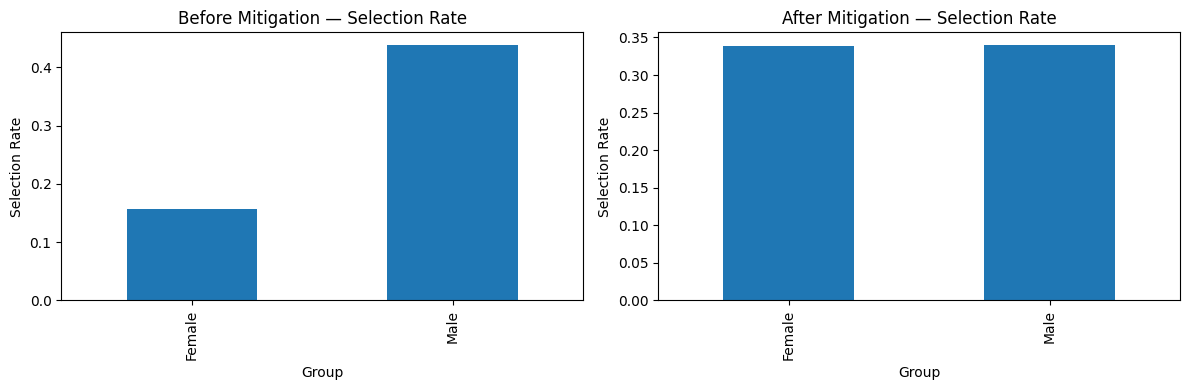

In [231]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
metric_frame.by_group["selection_rate"].plot(kind="bar", ax=ax[0], title="Before Mitigation — Selection Rate")
metric_frame_mitig.by_group["selection_rate"].plot(kind="bar", ax=ax[1], title="After Mitigation — Selection Rate")
for a in ax:
    a.set_xlabel("Group"); a.set_ylabel("Selection Rate")
plt.tight_layout(); plt.show()

In [232]:
# Map LR coefficients back to human-readable feature names from OHE
ohe = pipe.named_steps["prep"].named_transformers_["cat"]
feature_names = []

# One-hot expanded categorical names
cat_feature_names = ohe.get_feature_names_out(categorical_cols).tolist()
# Numeric names passthrough
feature_names = cat_feature_names + numeric_cols

coefs = pipe.named_steps["model"].coef_.ravel()
importance = pd.DataFrame({
    "feature": feature_names,
    "coef": coefs,
    "abs_coef": np.abs(coefs)
}).sort_values("abs_coef", ascending=False)

top_n = 15
print(f"Top {top_n} features by absolute coefficient (magnitude):")
display(importance.head(top_n))

Top 15 features by absolute coefficient (magnitude):


,feature,coef,abs_coef
27,marital_status_Never-married,-1.408637,1.408637
47,relationship_Own-child,-1.090285,1.090285
37,occupation_Other-service,-0.924383,0.924383
33,occupation_Exec-managerial,0.898186,0.898186
25,marital_status_Married-civ-spouse,0.833762,0.833762
4,workclass_Self-emp-not-inc,-0.691000,0.691000
48,relationship_Unmarried,-0.662108,0.662108
39,occupation_Prof-specialty,0.601373,0.601373
49,relationship_Wife,0.596455,0.596455
18,education_HS-grad,-0.578286,0.578286


In [233]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer, f1_score
import pandas as pd

# Build F1 scorer for your string labels
f1_pos = make_scorer(f1_score, pos_label=">50K")

# Use ONLY the columns that the ColumnTransformer consumes,
# and in the same order
X_valid_used = X_valid[categorical_cols + numeric_cols]

perm = permutation_importance(
    pipe,
    X_valid_used,
    y_valid,
    n_repeats=5,
    random_state=42,
    scoring=f1_pos
)

# Feature names must match the original input columns given to permutation_importance
feature_names = X_valid_used.columns.tolist()

perm_imp = pd.DataFrame({
    "feature": feature_names,
    "importance_mean": perm.importances_mean,
    "importance_std": perm.importances_std
}).sort_values("importance_mean", ascending=False)

print("Permutation Importance (validation) — Top 15")
display(perm_imp.head(15))

Permutation Importance (validation) — Top 15


,feature,importance_mean,importance_std
2,marital_status,0.089026,0.006330
10,capital_gain,0.037544,0.002573
3,occupation,0.029136,0.002748
4,relationship,0.017572,0.006912
1,education,0.016053,0.002135
11,capital_loss,0.010057,0.001217
0,workclass,0.005231,0.001515
7,age,0.003993,0.002764
9,education_num,0.003613,0.001183
12,hours_per_week,0.001581,0.002623


In [234]:
favored_before = metric_frame.by_group["selection_rate"].idxmax()
favored_after  = metric_frame_mitig.by_group["selection_rate"].idxmax()

summary = pd.DataFrame({
    "Accuracy": [acc, acc_mitig],
    "F1 (>50K)": [f1, f1_mitig],
    "DP Difference (↓ better)": [dp_diff, dp_diff_mitig],
    "DP Ratio (→1 better)": [dp_ratio, dp_ratio_mitig],
    "Favored group (selection rate)": [favored_before, favored_after]
}, index=["Before Mitigation", "After Mitigation"])

print("=== FairHire — Phase 2 KPI Summary ===")
display(summary)

# Also surface a plain-english bias KPI:
gap_before = 100 * (metric_frame.by_group["selection_rate"].max() - metric_frame.by_group["selection_rate"].min())
gap_after  = 100 * (metric_frame_mitig.by_group["selection_rate"].max() - metric_frame_mitig.by_group["selection_rate"].min())
print(f"\nPlain-English KPI: selection-rate gap reduced from {gap_before:.2f}% to {gap_after:.2f}%.")

=== FairHire — Phase 2 KPI Summary ===


,Accuracy,F1 (>50K),DP Difference (↓ better),DP Ratio (→1 better),Favored group (selection rate)
Before Mitigation,0.798452,0.660205,0.282210,0.356238,Male
After Mitigation,0.784411,0.633045,0.000736,0.997835,Male



Plain-English KPI: selection-rate gap reduced from 28.22% to 0.07%.


In [235]:
from scipy import stats

def bias_stats_analysis(y_true, y_pred, sensitive_series, positive_label=">50K"):
    """
    Computes detailed bias KPIs and statistical tests for each sensitive group.
    """
    df_eval = pd.DataFrame({
        "true": y_true,
        "pred": y_pred,
        "group": sensitive_series
    })
    df_eval["pred_binary"] = (df_eval["pred"] == positive_label).astype(int)
    df_eval["true_binary"] = (df_eval["true"] == positive_label).astype(int)

    results = []

    for g in df_eval["group"].unique():
        subset = df_eval[df_eval["group"] == g]
        sr = subset["pred_binary"].mean()        # selection rate
        tpr = ((subset["true_binary"] == 1) & (subset["pred_binary"] == 1)).sum() / max((subset["true_binary"] == 1).sum(), 1)
        fpr = ((subset["true_binary"] == 0) & (subset["pred_binary"] == 1)).sum() / max((subset["true_binary"] == 0).sum(), 1)
        results.append({
            "Group": g,
            "Selection Rate": sr,
            "True Positive Rate": tpr,
            "False Positive Rate": fpr,
            "Sample Size": len(subset)
        })

    results_df = pd.DataFrame(results).set_index("Group")
    
    # --- Statistical significance (chi-square test for independence) ---
    contingency = pd.crosstab(df_eval["group"], df_eval["pred_binary"])
    chi2, p_val, _, _ = stats.chi2_contingency(contingency)

    print("Chi-Square Bias Significance Test:")
    print(f"  χ² = {chi2:.3f}, p = {p_val:.6f}")
    if p_val < 0.05:
        print("  ⚠️ Statistically significant disparity detected (p < 0.05).")
    else:
        print("  ✅ No statistically significant group disparity detected.")

    # --- Effect size (Cohen's d on selection rates) ---
    if len(results_df) == 2:
        groups = list(results_df.index)
        d = (
            (results_df.loc[groups[0], "Selection Rate"] - results_df.loc[groups[1], "Selection Rate"])
            / np.sqrt((results_df["Selection Rate"].var()))
        )
        print(f"Cohen’s d (effect size of selection gap): {d:.3f}")
    else:
        print("Multiple groups: use max–min selection gap instead.")

    return results_df, p_val

# --- Run the bias stats analysis before and after mitigation ---
print("=== Bias Statistics — Before Mitigation ===")
stats_before, p_before = bias_stats_analysis(y_valid, y_pred, X_valid_full[SENSITIVE_FEATURE])

print("\n=== Bias Statistics — After Mitigation ===")
stats_after, p_after = bias_stats_analysis(y_valid, y_pred_mitigated, X_valid_full[SENSITIVE_FEATURE])

display(stats_before.round(3))
display(stats_after.round(3))

=== Bias Statistics — Before Mitigation ===
Chi-Square Bias Significance Test:
  χ² = 703.213, p = 0.000000
  ⚠️ Statistically significant disparity detected (p < 0.05).
Cohen’s d (effect size of selection gap): -1.414

=== Bias Statistics — After Mitigation ===
Chi-Square Bias Significance Test:
  χ² = 0.002, p = 0.963417
  ✅ No statistically significant group disparity detected.
Cohen’s d (effect size of selection gap): -1.414


,Selection Rate,True Positive Rate,False Positive Rate,Sample Size
Group,,,,
Female,0.156,0.694,0.084,2984
Male,0.438,0.808,0.271,6061


,Selection Rate,True Positive Rate,False Positive Rate,Sample Size
Group,,,,
Female,0.339,0.929,0.260,2984
Male,0.340,0.717,0.169,6061


In [236]:
# Combine main KPIs before vs after
def fairness_improvement_report(before_frame, after_frame):
    improvement = pd.DataFrame({
        "Selection Rate Gap (%)": [
            100*(before_frame["Selection Rate"].max() - before_frame["Selection Rate"].min()),
            100*(after_frame["Selection Rate"].max() - after_frame["Selection Rate"].min())
        ],
        "TPR Gap (%)": [
            100*(before_frame["True Positive Rate"].max() - before_frame["True Positive Rate"].min()),
            100*(after_frame["True Positive Rate"].max() - after_frame["True Positive Rate"].min())
        ],
        "FPR Gap (%)": [
            100*(before_frame["False Positive Rate"].max() - before_frame["False Positive Rate"].min()),
            100*(after_frame["False Positive Rate"].max() - after_frame["False Positive Rate"].min())
        ],
    }, index=["Before", "After"])
    improvement["Bias Reduction (%)"] = 100 * (improvement.iloc[0] - improvement.iloc[1]) / improvement.iloc[0]
    return improvement

fairness_improvement = fairness_improvement_report(stats_before, stats_after)
print("=== Fairness Gap & Improvement Summary ===")
display(fairness_improvement.round(2))

=== Fairness Gap & Improvement Summary ===


,Selection Rate Gap (%),TPR Gap (%),FPR Gap (%),Bias Reduction (%)
Before,28.22,11.38,18.71,NaN
After,0.07,21.24,9.08,NaN


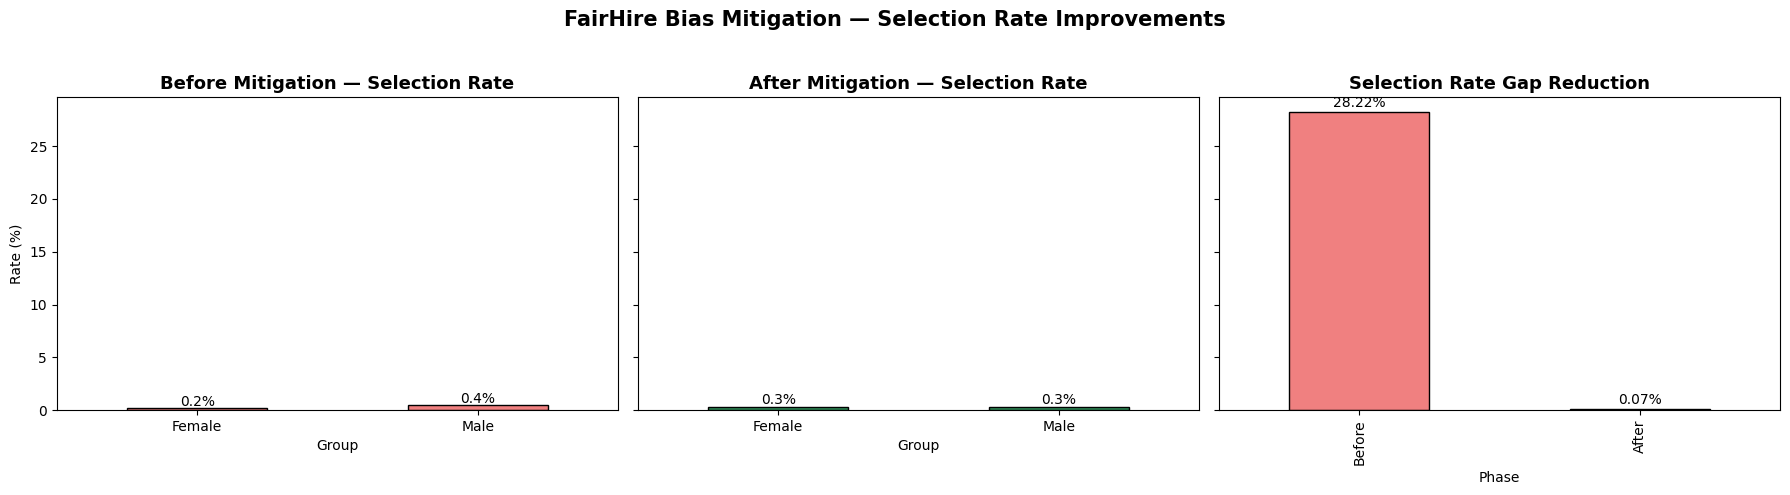

In [237]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# 1) Before Mitigation
stats_before["Selection Rate"].plot(
    kind="bar", ax=axes[0], color="lightcoral", edgecolor="black"
)
axes[0].set_title("Before Mitigation — Selection Rate", fontsize=13, fontweight="bold")
axes[0].set_xlabel("Group")
axes[0].set_ylabel("Rate (%)")
axes[0].tick_params(axis='x', labelrotation=0)
for i, val in enumerate(stats_before["Selection Rate"]):
    axes[0].text(i, val + 0.2, f"{val:.1f}%", ha="center", fontsize=10)

# 2) After Mitigation
stats_after["Selection Rate"].plot(
    kind="bar", ax=axes[1], color="seagreen", edgecolor="black"
)
axes[1].set_title("After Mitigation — Selection Rate", fontsize=13, fontweight="bold")
axes[1].set_xlabel("Group")
axes[1].tick_params(axis='x', labelrotation=0)
for i, val in enumerate(stats_after["Selection Rate"]):
    axes[1].text(i, val + 0.2, f"{val:.1f}%", ha="center", fontsize=10)

# 3) Improvement Gap
improv = fairness_improvement.loc["Before":"After", "Selection Rate Gap (%)"]
improv.plot(
    kind="bar", ax=axes[2], color=["lightcoral", "seagreen"], edgecolor="black"
)
axes[2].set_title("Selection Rate Gap Reduction", fontsize=13, fontweight="bold")
axes[2].set_xlabel("Phase")
for i, val in enumerate(improv):
    axes[2].text(i, val + 0.5, f"{val:.2f}%", ha="center", fontsize=10)

plt.suptitle("FairHire Bias Mitigation — Selection Rate Improvements", fontsize=15, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


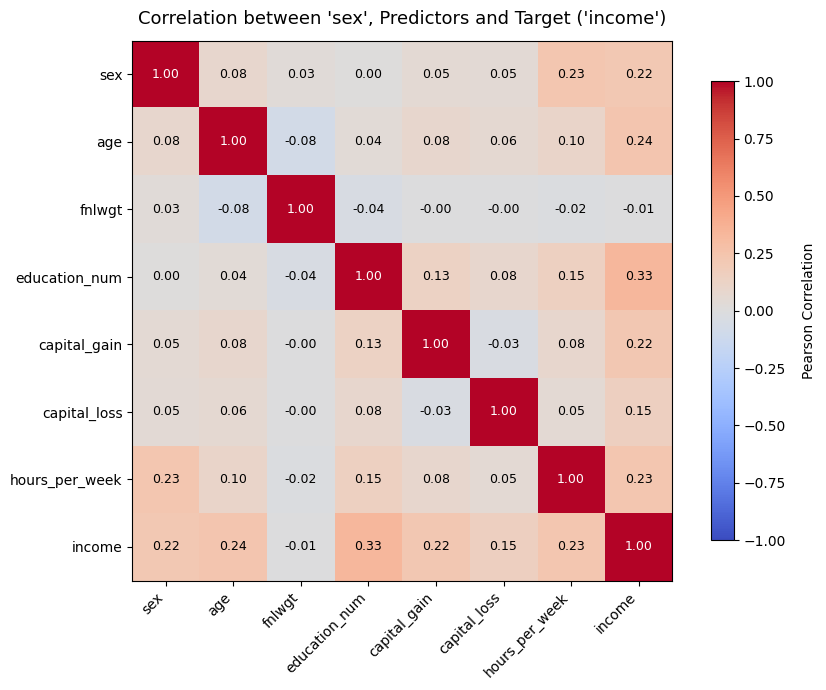

Top numeric correlations with target (absolute value):


education_num     0.332800
age               0.237040
hours_per_week    0.227199
capital_gain      0.221034
capital_loss      0.148687
fnlwgt           -0.007264
Name: income, dtype: float64

In [238]:
# --- Correlation Heatmap: Sensitive feature, Target, and Numerics ---

# 1) Make a safe copy and ensure numeric encodings
df_corr = df.copy()

# Binary-encode target: 1 = positive outcome (">50K"), 0 = otherwise
df_corr[TARGET] = (df_corr[TARGET].astype(str).str.strip().str.replace('.', '', regex=False) == ">50K").astype(int)

# Encode sensitive feature to numeric codes (e.g., Female=0, Male=1 for 'sex')
df_corr[SENSITIVE_FEATURE] = df_corr[SENSITIVE_FEATURE].astype("category").cat.codes

# 2) Build the column list safely (guard against missing numerics)
num_cols_available = [c for c in numeric_cols if c in df_corr.columns]
cols_for_corr = [SENSITIVE_FEATURE, TARGET] + num_cols_available

# 3) Compute Pearson correlations (drop rows with any NaNs in these columns)
corr_matrix = df_corr[cols_for_corr].dropna().corr(method="pearson")

# 4) Improve readability: order columns (sensitive, predictors..., target)
ordered_cols = [SENSITIVE_FEATURE] + [c for c in corr_matrix.columns if c not in [SENSITIVE_FEATURE, TARGET]] + [TARGET]
corr_matrix = corr_matrix.loc[ordered_cols, ordered_cols]

# 5) Matplotlib heatmap with annotations
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(9, 7))
im = ax.imshow(corr_matrix.values, cmap="coolwarm", vmin=-1, vmax=1)

# Ticks & labels
ax.set_xticks(np.arange(len(corr_matrix.columns)))
ax.set_yticks(np.arange(len(corr_matrix.index)))
ax.set_xticklabels(corr_matrix.columns, rotation=45, ha="right", fontsize=10)
ax.set_yticklabels(corr_matrix.index, fontsize=10)

# Annotate each cell with the correlation value
for i in range(corr_matrix.shape[0]):
    for j in range(corr_matrix.shape[1]):
        val = corr_matrix.values[i, j]
        ax.text(j, i, f"{val:.2f}", ha="center", va="center",
                color="black" if abs(val) < 0.6 else "white", fontsize=9)

# Colorbar and titles
cbar = plt.colorbar(im, ax=ax, shrink=0.85)
cbar.set_label("Pearson Correlation", rotation=90, labelpad=12)
ax.set_title(f"Correlation between '{SENSITIVE_FEATURE}', Predictors and Target ('{TARGET}')", fontsize=13, pad=12)

plt.tight_layout()
plt.show()

# 6) Surface the strongest numeric correlations with the target
print("Top numeric correlations with target (absolute value):")
target_corr = corr_matrix[TARGET].drop([SENSITIVE_FEATURE, TARGET], errors="ignore")
display(target_corr.reindex(target_corr.abs().sort_values(ascending=False).index))

In [239]:
# Group confusion matrix KPIs
def group_confusion(df_true, df_pred, groups):
    recs = []
    for g in np.unique(groups):
        mask = (groups == g)
        tn, fp, fn, tp = confusion_matrix(df_true[mask], df_pred[mask], labels=["<=50K",">50K"]).ravel()
        prec = tp / (tp + fp + 1e-8)
        rec  = tp / (tp + fn + 1e-8)
        fpr  = fp / (fp + tn + 1e-8)
        recs.append({
            "Group": g, "Precision": prec, "Recall": rec, "False Pos Rate": fpr,
            "Support": mask.sum()
        })
    return pd.DataFrame(recs).set_index("Group")

kpi_perf_before = group_confusion(y_valid.values, y_pred, X_valid_full[SENSITIVE_FEATURE].values)
kpi_perf_after  = group_confusion(y_valid.values, y_pred_mitigated, X_valid_full[SENSITIVE_FEATURE].values)

print("=== Group Performance (KPI) — Before Mitigation ===")
display(kpi_perf_before.round(3))
print("=== Group Performance (KPI) — After Mitigation ===")
display(kpi_perf_after.round(3))

=== Group Performance (KPI) — Before Mitigation ===


,Precision,Recall,False Pos Rate,Support
Group,,,,
Female,0.526,0.694,0.084,2984
Male,0.574,0.808,0.271,6061


=== Group Performance (KPI) — After Mitigation ===


,Precision,Recall,False Pos Rate,Support
Group,,,,
Female,0.324,0.929,0.260,2984
Male,0.657,0.717,0.169,6061


In [240]:
exec_kpis = pd.DataFrame({
    "Accuracy": [acc, acc_mitig],
    "F1 Score": [f1, f1_mitig],
    "DP Diff (↓ better)": [dp_diff, dp_diff_mitig],
    "DP Ratio (→1 better)": [dp_ratio, dp_ratio_mitig],
    "Chi² p-value": [p_before, p_after],
    "Favored Group": [
        stats_before["Selection Rate"].idxmax(),
        stats_after["Selection Rate"].idxmax()
    ],
    "Bias Gap %": [
        100*(stats_before["Selection Rate"].max() - stats_before["Selection Rate"].min()),
        100*(stats_after["Selection Rate"].max() - stats_after["Selection Rate"].min())
    ]
}, index=["Before", "After"])

print("=== FairHire Phase 2 — Executive KPI Dashboard ===")
display(exec_kpis.round(3))

=== FairHire Phase 2 — Executive KPI Dashboard ===


,Accuracy,F1 Score,DP Diff (↓ better),DP Ratio (→1 better),Chi² p-value,Favored Group,Bias Gap %
Before,0.798,0.660,0.282,0.356,0.000,Male,28.221
After,0.784,0.633,0.001,0.998,0.963,Male,0.074
